# Testing
### Wohnungsbestand nach Zimmerzahl, Miete/Eigentum, Bauperiode, Eigentumsgruppe und Stadtquartier, seit 2008
Datum: 03.02.2022

### Importiere die notwendigen Packages

In [2]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly

In [3]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
#from datetime import datetime
import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns


Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [4]:
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [5]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")


Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [6]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2022 2 datenstand:  0 time.struct_time(tm_year=2022, tm_mon=2, tm_mday=7, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=0, tm_yday=38, tm_isdst=-1)


Berechne die Variable Epoche um später das SAS-Datum in ein Unix-Datum umzuwandeln. Bei SAS beginnt die Epoche am 1.1.1960. Bei Unix am 1.1.1970.
Diese Variable wird beim CSV-Import benötigt.

In [7]:
epoch = datetime.datetime(1960, 1, 1)

### Importiere einen Datensatz 

- Beachte dabei die Notation des Pfades...
- Definiere mal aktuell noch keine weiteren Parameter beim Import

**Dataset auf INTEG Datenkatalog**:  https://data.integ.stadt-zuerich.ch/dataset/int_dwh_bau_best_whg_zizahl_wfl_bauperi_ea_quartier_jahr_od5081

**Dataset auf PROD Datenkatalog**:  https://data.stadt-zuerich.ch/dataset/bau_best_whg_zizahl_wfl_bauperi_ea_quartier_jahr_od5081


In [8]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "int";
print(status)

int


In [9]:
# Filepath
if status == "prod":
    fp = r"https://data.stadt-zuerich.ch/dataset/bau_best_whg_zizahl_wfl_bauperi_ea_quartier_jahr_od5081/download/BAU508OD5081.csv"
else:
    fp = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_best_whg_zizahl_wfl_bauperi_ea_quartier_jahr_od5081\BAU508OD5081.csv"   

print(fp)

\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH\bau_best_whg_zizahl_wfl_bauperi_ea_quartier_jahr_od5081\BAU508OD5081.csv


In [10]:
# Read the data
data2betested = pd.read_csv(
    fp
    , sep=','
    ,parse_dates=['StichtagDatJahr']
    # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
    #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
    ,low_memory=False    
    )

print('done')

done


In der Folge ein paar erste Tests:

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

In [11]:
#data2betested.head(6)

In [12]:
data2betested.dtypes

StichtagDatJahr    datetime64[ns]
QuarSort                    int64
QuarLang                   object
KreisSort                   int64
KreisLang                  object
ZimmerSort                  int64
ZimmerLang                 object
MietwohnungSort           float64
MietwohnungLang            object
BauperiodeSort              int64
BauperiodeLang             object
EigGruSort                  int64
EigGruLang                 object
AnzWhg                      int64
Wohnungsfl                  int64
dtype: object

In [13]:
data2betested.shape

(103296, 15)

Beschreibe einzelne Attribute

In [14]:
data2betested.describe()

,QuarSort,KreisSort,ZimmerSort,MietwohnungSort,BauperiodeSort,EigGruSort,AnzWhg,Wohnungsfl
count,103296,103296,103296,58814,103296,103296,103296,103296
mean,71,7,4,1,6,3,29,2287
std,34,3,2,0,3,1,64,4802
min,11,1,1,0,1,1,1,7
25%,41,4,2,0,3,3,2,238
50%,73,7,4,1,5,4,8,707
75%,101,10,5,1,8,4,26,2112
max,123,12,8,1,12,5,1474,107074


Wie viele Nullwerte gibt es im Datensatz?

In [15]:
data2betested.isnull().sum()

StichtagDatJahr        0
QuarSort               0
QuarLang               0
KreisSort              0
KreisLang              0
ZimmerSort             0
ZimmerLang             0
MietwohnungSort    44482
MietwohnungLang        0
BauperiodeSort         0
BauperiodeLang         0
EigGruSort             0
EigGruLang             0
AnzWhg                 0
Wohnungsfl             0
dtype: int64

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [16]:
data2betested = data2betested.set_index("StichtagDatJahr")

In [17]:
data2betested.info()
data2betested.index.day.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103296 entries, 2008-01-01 to 2021-01-01
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   QuarSort         103296 non-null  int64  
 1   QuarLang         103296 non-null  object 
 2   KreisSort        103296 non-null  int64  
 3   KreisLang        103296 non-null  object 
 4   ZimmerSort       103296 non-null  int64  
 5   ZimmerLang       103296 non-null  object 
 6   MietwohnungSort  58814 non-null   float64
 7   MietwohnungLang  103296 non-null  object 
 8   BauperiodeSort   103296 non-null  int64  
 9   BauperiodeLang   103296 non-null  object 
 10  EigGruSort       103296 non-null  int64  
 11  EigGruLang       103296 non-null  object 
 12  AnzWhg           103296 non-null  int64  
 13  Wohnungsfl       103296 non-null  int64  
dtypes: float64(1), int64(7), object(6)
memory usage: 11.8+ MB


Int64Index([1], dtype='int64', name='StichtagDatJahr')

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [18]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [19]:
data2betested.loc["2009"].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,QuarSort,QuarLang,KreisSort,KreisLang,ZimmerSort,ZimmerLang,MietwohnungSort,MietwohnungLang,BauperiodeSort,BauperiodeLang,EigGruSort,EigGruLang,AnzWhg,Wohnungsfl
StichtagDatJahr,,,,,,,,,,,,,,
2009-01-01,11,Rathaus,1,Kreis 1,1,1 Zimmer,NaN,Unbekannt,1,Vor 1893,1,Öffentliche Hand,103,3661
2009-01-01,11,Rathaus,1,Kreis 1,1,1 Zimmer,NaN,Unbekannt,1,Vor 1893,3,Übrige private Gesell.,79,2084


### Visualisierungen nach Zeitausschnitten

#### Entwicklung Wohnungsbestand nach Bauperiode

In [20]:
data2betested.dtypes

QuarSort             int64
QuarLang            object
KreisSort            int64
KreisLang           object
ZimmerSort           int64
ZimmerLang          object
MietwohnungSort    float64
MietwohnungLang     object
BauperiodeSort       int64
BauperiodeLang      object
EigGruSort           int64
EigGruLang          object
AnzWhg               int64
Wohnungsfl           int64
dtype: object

In [21]:
#.groupby(['StichtagDatJahr', 'BauperiodeSort', 'BauperiodeLang','ZimmerSort', 'ZimmerLang' ])

myAgg = data2betested.loc["2009":"2021"]\
    .groupby(['StichtagDatJahr', 'BauperiodeSort', 'BauperiodeLang' ]) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum'), sum_Wohnungsfl=('Wohnungsfl', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,BauperiodeSort,BauperiodeLang,sum_AnzWhg,sum_Wohnungsfl
0,2009-01-01,1,Vor 1893,10638,833846
1,2009-01-01,2,1893 - 1930,50204,4044865
2,2009-01-01,3,1931 - 1940,20847,1568949


In [22]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['BauperiodeLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_AnzWhg > 1'), title="Title").encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='Jahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzWhg', axis=alt.Axis(title='Anz. Wohnungen'))
    , color=alt.Color('BauperiodeLang', legend=alt.Legend(title="Baujahrperiode", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'BauperiodeLang','sum_AnzWhg']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Entwicklung der Wohnungsflächen nach Eigentumsgruppe

In [23]:
#data2betested.dtypes

In [24]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2009":"2021"]\
    .groupby(['StichtagDatJahr', 'EigGruLang' ]) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum'), sum_Wohnungsfl=('Wohnungsfl', 'sum') ) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg.reset_index().head(3)

,StichtagDatJahr,EigGruLang,sum_AnzWhg,sum_Wohnungsfl
0,2009-01-01,Im Stockwerkeigentum,15897,1496235
1,2009-01-01,Natürliche Personen,86475,6615823
2,2009-01-01,Wohnbaugenossenschaften,36391,2714870


In [25]:
highlight = alt.selection(type='single', on='mouseover',
                          fields=['EigGruLang'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_Wohnungsfl > 1'), title="Title").encode(
    x=alt.X('StichtagDatJahr', axis=alt.Axis(title='StichtagDatJahr'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_AnzWhg', axis=alt.Axis(title='Anz. Wohnungen'))
    , color=alt.Color('EigGruLang', legend=alt.Legend(title="Eigentumsart", orient="right"))  
    ,tooltip=['StichtagDatJahr', 'EigGruLang','sum_AnzWhg']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines + points

alt.LayerChart(...)

#### Barcharts mit Seaborn

In [26]:
#data2betested.dtypes

In [27]:
myAggBar = data2betested.loc["2009":"2021"]\
    .groupby(['StichtagDatJahr', 'EigGruLang' ]) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(3)

,StichtagDatJahr,EigGruLang,sum_AnzWhg
0,2009-01-01,Im Stockwerkeigentum,15897
1,2009-01-01,Natürliche Personen,86475
2,2009-01-01,Wohnbaugenossenschaften,36391


In [28]:
#help(sns.catplot)     

In [29]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

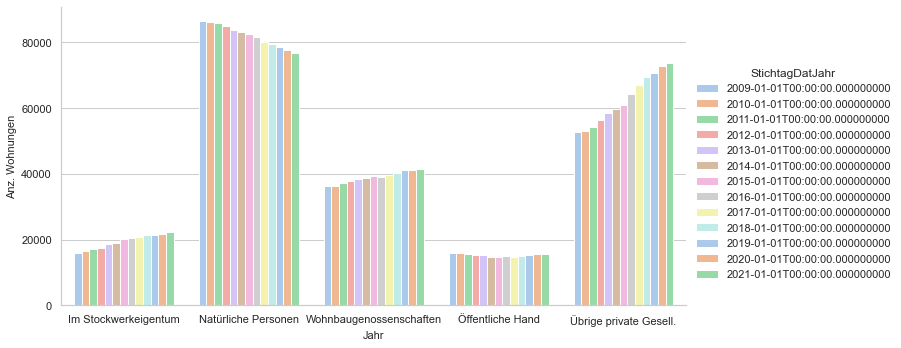

In [30]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="EigGruLang"
            , y="sum_AnzWhg"
            , hue="StichtagDatJahr"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Wohnungen', fontsize=11)


In [31]:
data2betested.dtypes

QuarSort             int64
QuarLang            object
KreisSort            int64
KreisLang           object
ZimmerSort           int64
ZimmerLang          object
MietwohnungSort    float64
MietwohnungLang     object
BauperiodeSort       int64
BauperiodeLang      object
EigGruSort           int64
EigGruLang          object
AnzWhg               int64
Wohnungsfl           int64
dtype: object

##### Entwicklung der Anzahl Wohnungen pro Kreis nach Bauperiode

In [32]:
myAggBar = data2betested.loc["2009":"2021"]\
    .groupby(['StichtagDatJahr', 'KreisSort','BauperiodeLang' ]) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum'), sum_Wohnungsfl=('Wohnungsfl', 'sum') ) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(2)

,StichtagDatJahr,KreisSort,BauperiodeLang,sum_AnzWhg,sum_Wohnungsfl
0,2009-01-01,1,1893 - 1930,158,11491
1,2009-01-01,9,1991 - 2000,943,87405


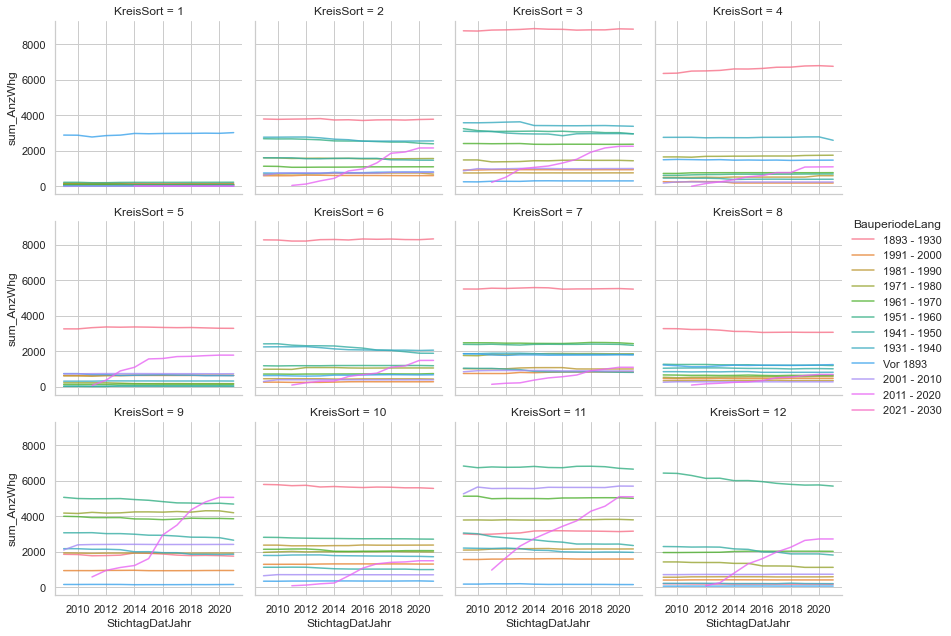

In [86]:
g = sns.FacetGrid(myAggBar.reset_index(), col="KreisSort", hue="BauperiodeLang", col_wrap=4, height=3,)
#g.map(sns.scatterplot, "Jahr", "sum_AnzWhg", alpha=.8)
g.map(sns.lineplot, "StichtagDatJahr","sum_AnzWhg",alpha=.8)
g.add_legend()

#g2 = sns.FacetGrid(myAggBar.reset_index(), col="KreisSort", hue="BauperiodeLang", col_wrap=4, height=3,)
#g2.map(sns.lineplot, "StichtagDatJahr","sum_Wohnungsfl",alpha=.8)
#g2.add_legend()

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Wohnungen nach Zimmerzahl, Bauperiode und Eigentumsart 2021

In [103]:
data2betested.dtypes

QuarSort             int64
QuarLang            object
KreisSort            int64
KreisLang           object
ZimmerSort           int64
ZimmerLang          object
MietwohnungSort    float64
MietwohnungLang     object
BauperiodeSort       int64
BauperiodeLang      object
EigGruSort           int64
EigGruLang          object
AnzWhg               int64
Wohnungsfl           int64
dtype: object

In [104]:
myTreemapAgg = data2betested.loc["2021"]\
    .groupby([ 'BauperiodeSort', 'BauperiodeLang','EigGruLang','ZimmerLang']) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum'), sum_Wohnungsfl=('Wohnungsfl', 'sum') ) \
    .sort_values('sum_AnzWhg', ascending=True) 

myTreemapAgg.reset_index().head(3)

,BauperiodeSort,BauperiodeLang,EigGruLang,ZimmerLang,sum_AnzWhg,sum_Wohnungsfl
0,2,1893 - 1930,Wohnbaugenossenschaften,Ab 8 Zimmer,1,225
1,4,1941 - 1950,Öffentliche Hand,6 Zimmer,1,159
2,12,2021 - 2030,Im Stockwerkeigentum,6 Zimmer,1,225


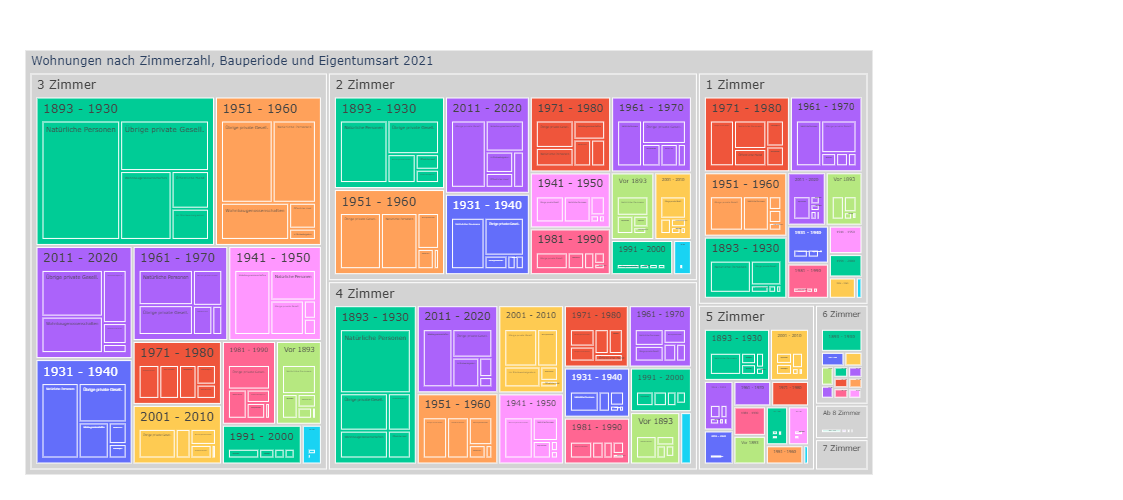

In [105]:
fig = px.treemap(myTreemapAgg.query('sum_AnzWhg >0').reset_index(), path=[px.Constant("Wohnungen nach Zimmerzahl, Bauperiode und Eigentumsart 2021")
                                                                                      ,'ZimmerLang', 'BauperiodeLang','EigGruLang']
                 , values='sum_AnzWhg'
                 , color='BauperiodeLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Wohnungen nach Stadtkreis, Zimmerzahl und Bauperiode 2021

In [106]:
data2betested.dtypes

QuarSort             int64
QuarLang            object
KreisSort            int64
KreisLang           object
ZimmerSort           int64
ZimmerLang          object
MietwohnungSort    float64
MietwohnungLang     object
BauperiodeSort       int64
BauperiodeLang      object
EigGruSort           int64
EigGruLang          object
AnzWhg               int64
Wohnungsfl           int64
dtype: object

In [107]:
myTreemapAgg = data2betested.loc["2021"]\
    .groupby([ 'KreisLang', 'BauperiodeSort', 'BauperiodeLang','ZimmerLang']) \
    .agg(sum_AnzWhg=('AnzWhg', 'sum'), sum_Wohnungsfl=('Wohnungsfl', 'sum') ) \
    .sort_values('sum_AnzWhg', ascending=True) 

myTreemapAgg.reset_index().head(3)

,KreisLang,BauperiodeSort,BauperiodeLang,ZimmerLang,sum_AnzWhg,sum_Wohnungsfl
0,Kreis 7,12,2021 - 2030,Ab 8 Zimmer,1,200
1,Kreis 10,12,2021 - 2030,6 Zimmer,1,236
2,Kreis 8,3,1931 - 1940,Ab 8 Zimmer,1,200


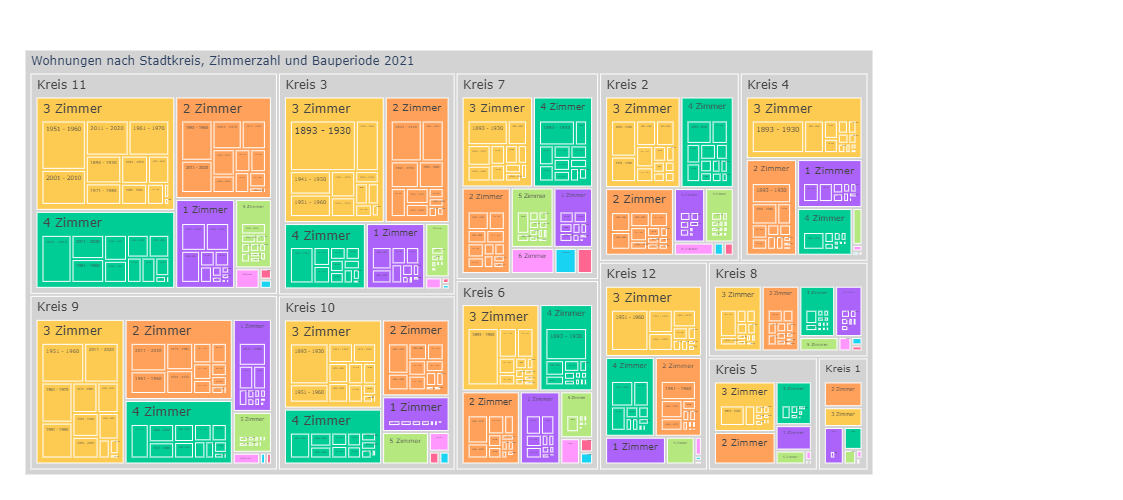

In [109]:
fig = px.treemap(myTreemapAgg.query('sum_AnzWhg >0').reset_index(), path=[px.Constant("Wohnungen nach Stadtkreis, Zimmerzahl und Bauperiode 2021")
                                                                                      ,'KreisLang','ZimmerLang', 'BauperiodeLang']
                 , values='sum_AnzWhg'
                 , color='ZimmerLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

#### Wohnungen nach Zimmerzahl, Stadtkreis und Bauperiode 2021

In [111]:
myTreemapAgg.query('sum_AnzWhg >0').reset_index().dtypes

KreisLang         object
BauperiodeSort     int64
BauperiodeLang    object
ZimmerLang        object
sum_AnzWhg         int64
sum_Wohnungsfl     int64
dtype: object

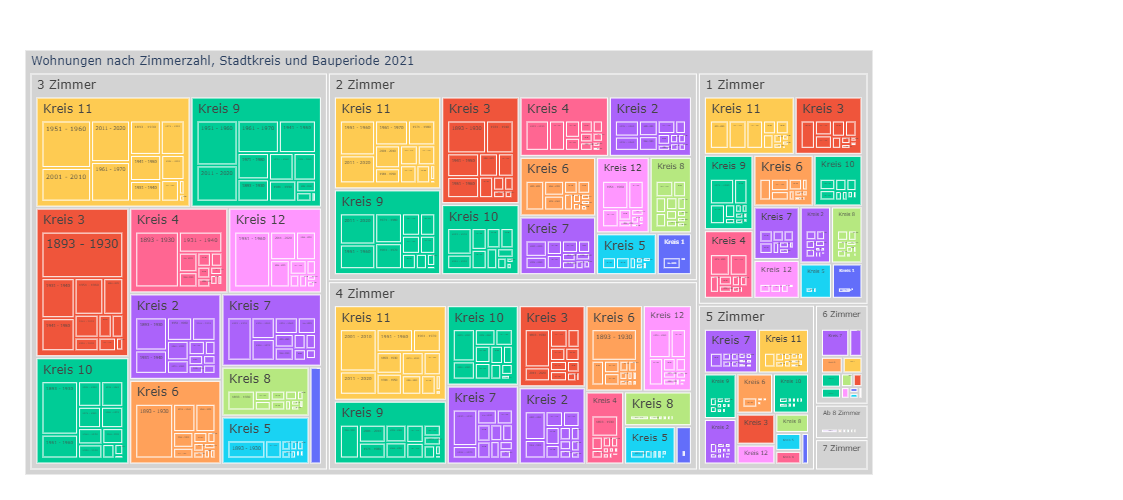

In [113]:
fig = px.treemap(myTreemapAgg.query('sum_AnzWhg >0').reset_index(), path=[px.Constant("Wohnungen nach Zimmerzahl, Stadtkreis und Bauperiode 2021")
                                                                                      ,'ZimmerLang','KreisLang', 'BauperiodeLang']
                 , values='sum_AnzWhg'
                 , color='KreisLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 , color_discrete_map={'(?)':'lightgrey','Alt-Wiedikon':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                #, color_continuous_scale='cividis'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=500
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [117]:
#data2betested.dtypes

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=881&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

## ---------------------- hier Plausi beendet

Liniendiagramm 
[Link zur Doku](https://altair-viz.github.io/gallery/multiline_highlight.html)

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [124]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


,id,kname,knr,objid,geometry
0,adm_stadtkreise_v.6,Kreis 7,7,6,"POLYGON ((8.54885 47.36602, 8.54901 47.36601, ..."


#### Statistische Zonen

In [115]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,stzname,stznr,geometry
0,adm_statzonen_map.1,Kreis 7,7,1,154,Hirslanden,73,Hegibach,7303,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statzonen_map.2,Kreis 7,7,2,89,Hirslanden,73,Klus,7302,"POLYGON ((8.57281 47.35806, 8.57278 47.35807, ..."


#### Statistische Quartiere

In [119]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


,id,kname,knr,objectid,objid,qname,qnr,geometry
0,adm_statistische_quartiere_map.1,Kreis 7,7,1,34,Hirslanden,73,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ..."
1,adm_statistische_quartiere_map.2,Kreis 8,8,2,33,Weinegg,83,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ..."


### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [127]:
data2betested.dtypes

StatZoneCd             int64
StatZone              object
QuarCd                 int64
QuarLang              object
KreisCd                int64
KreisLang             object
EigentumsartSort       int64
Eigentumsart          object
Whg_abgebrochen        int64
Whg_fertigerstellt     int64
dtype: object

In [137]:
myAgg = data2betested.loc["2021"]  \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_Whg_abgebrochen=('Whg_abgebrochen', 'sum'),sum_Whg_fertigerstellt=('Whg_fertigerstellt', 'sum')) \
    .sort_values('sum_Whg_abgebrochen', ascending=False) 

myAgg.reset_index().head(1)


,QuarLang,QuarCd,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,Albisrieden,91,282,89


In [138]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

,geometry,QuarCd,qname,knr
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7


In [139]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd')
gdf_adm_statistische_quartiere_map_joined.head(2)


,geometry,QuarCd,qname,knr,sum_Whg_abgebrochen,sum_Whg_fertigerstellt
0,"POLYGON ((8.55670 47.36406, 8.55682 47.36410, ...",73,Hirslanden,7,48,2
1,"POLYGON ((8.55670 47.36405, 8.55672 47.36403, ...",83,Weinegg,8,2,0


<AxesSubplot:>

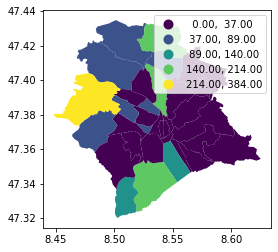

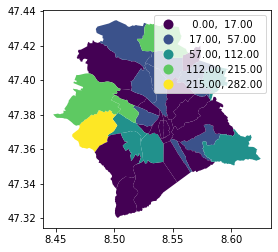

In [142]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True )

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='plasma', scheme='fisherjenks', legend=True )
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', cmap='cool', scheme='quantiles', legend=True )
#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

<AxesSubplot:>

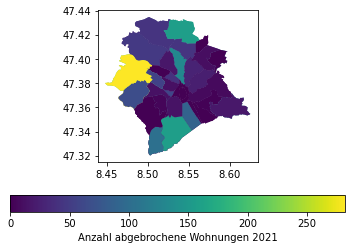

In [157]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', ax=ax, legend=True, legend_kwds={'label': "Anzahl abgebrochene Wohnungen 2021",'orientation': "horizontal"})
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_fertigerstellt', ax=ax, legend=False, legend_kwds={'label': "Anzahl fertigerstellte Wohnungen 2021",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=881&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**